In [120]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [121]:
valid_RPS_actions = [0, 1, 2]

def playRPS(action_p1, action_p2):
  if (action_p1 not in valid_RPS_actions) or (action_p2 not in valid_RPS_actions):
    raise Exception("Invalid Move Detected.")
    return -100
  
  if action_p1 == action_p2:
    return (-2, 0)
  
  if (action_p1 == 0 and action_p2 == 1) or (action_p1 == 1 and action_p2 == 2) or (action_p1 == 2 and action_p2 == 0):
    return (-10, 10)
  else:
    return (10, -10)

In [153]:
# Agent (a.k.a. player 1 settings)
agnt_hist = []
pseudo_probs = [[333334, 333333, 333333]]
agnt_preferences = np.concatenate((np.array(valid_RPS_actions, ndmin=2), pseudo_probs), axis = 0)

# This value affects the pseudo-probability distribution upon wins, losses, and draws.
incentive_factor = 10;

# Easier to use argmax by stuffing the eps_greedy method here.
def eps_greedy(prob):
  if prob >= random.random():
    return random.randint(0, len(valid_RPS_actions) - 1)
  else:
    return np.argmax(agnt_preferences[1, :])

# Player 2 Settings
# p2_history = [] <-- May be important provided 
p2_preferences = [0]
adjusted_p2_preferences = [2]

# Exploration rate of algorithm starting out when using epsilon greedy
initial_greed_rate = 0.999
running_gr = initial_greed_rate

# Minimum value for exploration rate
min_greed_rate = 0.0001

# The number of sets of rounds of games that will be played.
episodes = 10000

# How many times to play the game per episode.
rounds = 100

for epis in range(episodes):
  reward_total = 0
  running_gr = 0.999 ** (epis + 1)

  if epis >= 2500:
    p2_preferences = adjusted_p2_preferences

  for rnds in range(rounds):
    if running_gr >= min_greed_rate:
      agnt_pick = eps_greedy(running_gr)
    else:
      agnt_pick = eps_greedy(min_greed_rate)
    
    p2_pick = random.choice(p2_preferences)
    results = playRPS(agnt_pick, p2_pick)

    # This section updates the agent's probabilities for selecting a winning action.

    # Disincentivize losing actions.
    if results == (-10, 10):
      if agnt_pick == 0:
        selection = random.choice([1, 2])
        agnt_preferences[1, 0] = agnt_preferences[1, 0] - incentive_factor
      elif agnt_pick == 1:
        selection = random.choice([0, 2])
        agnt_preferences[1, 1] = agnt_preferences[1, 1] - incentive_factor
      elif agnt_pick == 2:
        selection = random.choice([0, 1])
        agnt_preferences[1, 2] = agnt_preferences[1, 2] - incentive_factor
      else:
        raise Exception("Invalid pick happened somewhere...") 
        
      agnt_preferences[1, selection] = agnt_preferences[1, selection] + incentive_factor

    # Incentivize winning actions.
    if results == (10, -10):
      if agnt_pick == 0:
        selection = random.choice([1, 2])
        agnt_preferences[1, 0] = agnt_preferences[1, 0] + incentive_factor
      elif agnt_pick == 1:
        selection = random.choice([0, 2])
        agnt_preferences[1, 1] = agnt_preferences[1, 1] + incentive_factor
      elif agnt_pick == 2:
        selection = random.choice([0, 1])
        agnt_preferences[1, 2] = agnt_preferences[1, 2] + incentive_factor
      else:
        raise Exception("Invalid pick happened somewhere...")

      agnt_preferences[1, selection] = agnt_preferences[1, selection] - incentive_factor

    # Disincentivize actions that lead to a draw.
    if results == (-2, 0):
      if p2_pick == 0:
        selection = random.choice([1, 2])
        agnt_preferences[1, 0] = agnt_preferences[1, 0] - incentive_factor
      elif p2_pick == 1:
        selection = random.choice([0, 2])
        agnt_preferences[1, 1] = agnt_preferences[1, 1] - incentive_factor
      elif p2_pick == 2:
        selection = random.choice([0, 1])
        agnt_preferences[1, 2] = agnt_preferences[1, 2] - incentive_factor
      else:
        raise Exception("Invalid pick happened somewhere...")

      agnt_preferences[1, selection] = agnt_preferences[1, selection] + incentive_factor

    
    reward_total += results[0]

  agnt_hist.append(reward_total)
  


[ 5636364 -2286747 -2349617]


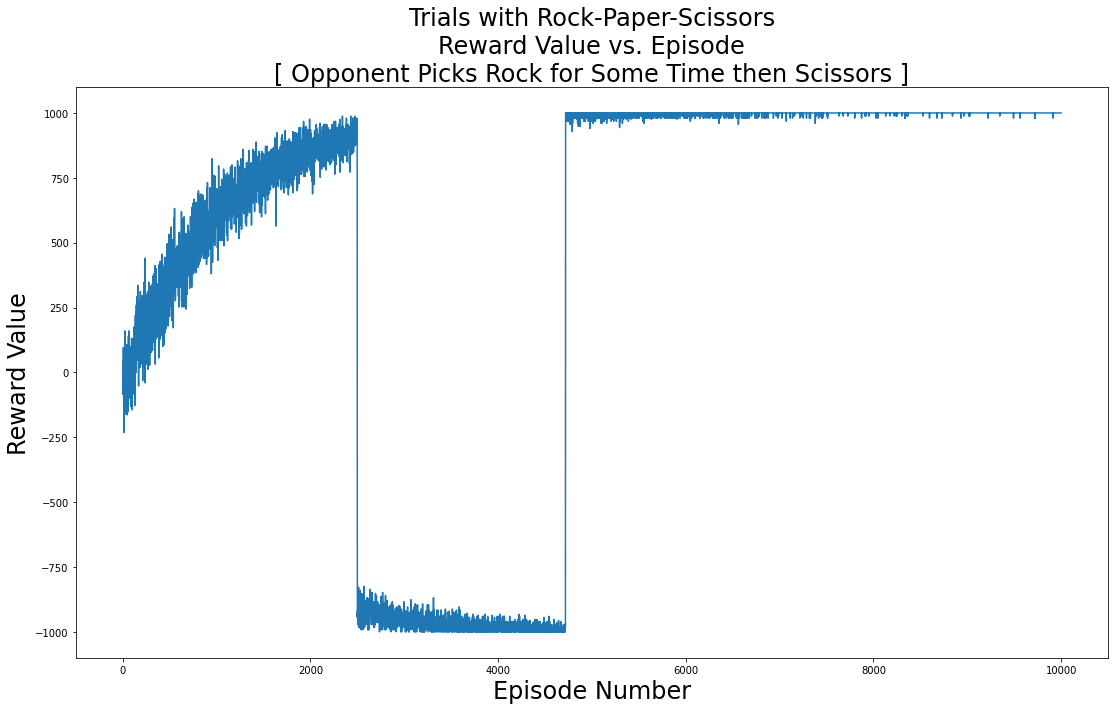

In [154]:
# Analytics Section
plt.plot(agnt_hist)
plt.xlabel('Episode Number', fontsize = 24)
plt.ylabel('Reward Value', fontsize = 24)
plt.title('Trials with Rock-Paper-Scissors\nReward Value vs. Episode\n[ Opponent Picks Rock for Some Time then Scissors ]', fontsize = 24)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
print(agnt_preferences[1, :])